# Check that the data is properly segmented and doesn't have absurd variance and mean

In [27]:
# nilearn imports
from nilearn.plotting import plot_roi, plot_stat_map, plot_anat, view_img
from nilearn.image import mean_img, load_img, math_img, new_img_like

In [4]:
# sklearn imports
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [5]:
# utility imports
import numpy as np
from matplotlib import pyplot as plt
import os.path
from joblib import dump, load
import tqdm
import pandas as pd

In [6]:
### Remove useless warnings from scikit learn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [7]:
def initialize(movie):
    # Generate folders for organized storage
    folders = ["fmri_mean_{}", "wards_{}", "fmri_ready_{}", "results"]
    for folder in folders :
        folder_name = folder.format(movie)
        try :
            os.mkdir(folder_name)
        except OSError :
            print("Folder already exists, skipping creation ({})".format(folder_name))
        else :
            print("Folder created  ({})".format(folder_name))

    result_folders = ["results/{}_conv{}".format(movie, id_layer) for id_layer in range(1,8)]
    for result_folder in result_folders :
        try :
            os.mkdir(result_folder)
        except OSError :
            print("Folder already exists, skipping creation ({})".format(result_folder))
        else :
            print("Folder created ({})".format(result_folder))
    
    # Set the differents path to data and folders

    # path to dataset of Sherlock or Merlin or TwilightZone
    if movie in ("sherlock","merlin"):
        # fmri data location
        local_movie_path = "/home/brain/datasets/SherlockMerlin_ds001110/"
        
        # mask name
        movie_mask =  "{}Movie_bold_space-T1w_brainmask.nii.gz".format(movie.capitalize())
        generic_mask_name = "/home/brain/datasets/SherlockMerlin_ds001110/sub-{:02d}/func/sub-{:02d}_task-" + movie_mask
        
        # fmri file name
        generic_filename = "sub-{:02d}_task-" + "{}Movie_bold_space-T1w_preproc.nii.gz".format(movie.capitalize())
        
        # anat file name
        anat_filename = "/home/brain/victor/datasets/fmri_anat_{}/".format(movie) + "sub-{:02d}.nii.gz"
        
    elif movie == "twilight-zone" :
        # fmri data location
        local_movie_path = "/home/brain/victor/datasets/twilight-zone"
        
        # there are no pre-existing masks
        generic_mask_name = ""
        
        # fmri file name
        generic_filename = "sub-{:02d}_task-watchmovie_bold.nii.gz"
    else :
        raise ValueError("The movie name has to be 'twilight-zone', 'merlin' or 'sherlock'")

        
    # locate the folder containing feature vectors extracted from soundnet for the corresponding movie (merlin_pytorch or sherlock_pytorch
    feature_folder = "soundnet_features/{}_pytorch/".format(movie)

    # folder for storing the resulting r2 brain maps
    folder_name = "results/{}_".format(movie)
    result_folder = folder_name + "conv{}/"
    
    # Configure the subjects corresponding to the movie : 
    # Sherlock : [1,18]\{5} 
    # Merlin : [19,37]\{25}
    # Twilight-zone : [1,25]
    id_subjects = {
    "sherlock": (1,18,5),
    "merlin": (19,37,25),
    "twilight-zone": (1,25,0)
    }

    sub_values = id_subjects[movie]
    
    return local_movie_path, generic_mask_name, generic_filename, anat_filename, feature_folder, result_folder, sub_values


In [221]:
# Movie has to be 'sherlock', 'merlin' or 'twilight-zone'
movie = 'sherlock'
local_movie_path, generic_mask_name, generic_filename, anat_filename, feature_folder, result_folder, sub_values = initialize(movie)
min_sub, max_sub, null_sub = sub_values

Folder already exists, skipping creation (fmri_mean_sherlock)
Folder already exists, skipping creation (wards_sherlock)
Folder already exists, skipping creation (fmri_ready_sherlock)
Folder already exists, skipping creation (results)
Folder already exists, skipping creation (results/sherlock_conv1)
Folder already exists, skipping creation (results/sherlock_conv2)
Folder already exists, skipping creation (results/sherlock_conv3)
Folder already exists, skipping creation (results/sherlock_conv4)
Folder already exists, skipping creation (results/sherlock_conv5)
Folder already exists, skipping creation (results/sherlock_conv6)
Folder already exists, skipping creation (results/sherlock_conv7)


In [222]:
def load_fmri(id_subject):
    folder_name = "sub-{:02d}/func".format(id_subject)
    subject_filename = generic_filename.format(id_subject)
    fmri_filename = os.path.join(local_movie_path,folder_name, subject_filename)
    fmri = load_img(fmri_filename)
    return fmri

In [223]:
def compute_std(id_subject):
    fmri = load_fmri(id_subject)
    fmri_data = fmri.get_data()
    std_img = np.std(fmri_data, axis=3)
    return std_img

In [224]:
def compute_mean(id_subject):
    fmri = load_fmri(id_subject)
    fmri_data = fmri.get_data()
    mean_img = np.mean(fmri_data, axis=3)
    return mean_img
        


In [225]:
def load_anat(id_subject):
    return anat_filename.format(id_subject)

In [226]:
def load_mean(id_subject):
    return "fmri_mean_{}/sub-{:02d}.nii.gz".format(movie,id_subject)

In [227]:
def load_mask(id_subject):
    return generic_mask_name.format(id_subject, id_subject)
    

In [228]:
def plot_std(id_subject):
    std = compute_std(id_subject)
    mean = load_mean(id_subject)
    std_img = new_img_like(mean, std)
    anat = load_anat(id_subject)
    mask_img = load_mask(id_subject)
    title = "{} subject {}".format(movie, id_subject)
    plot_anat(anat,cut_coords=8,display_mode='x', title = title, dim = -0.5).add_contours(mask_img)
    plt.show()
    plot_anat(anat, cut_coords=8,display_mode='y', title = title, dim = -0.5).add_contours(mask_img)
    plt.show()
    plot_anat(anat,cut_coords=8,display_mode='z', title = title, dim = -0.5).add_contours(mask_img)
    plt.show()

    #plot_stat_map(std_img, bg_img = mean ,title = "{} subject {}".format(movie, id_subject))

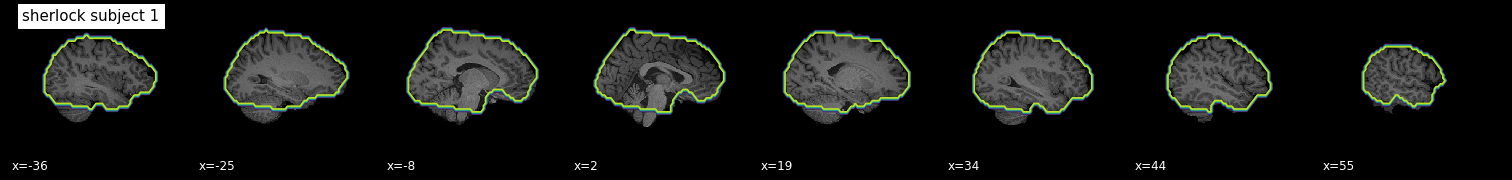

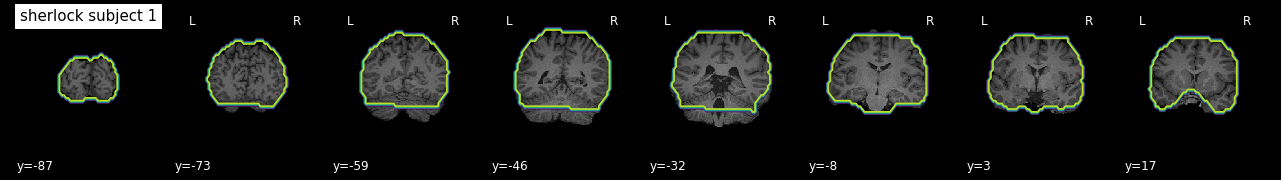

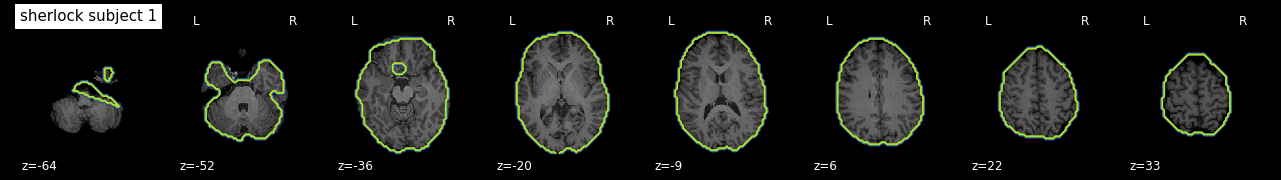

In [229]:
plot_std(min_sub)

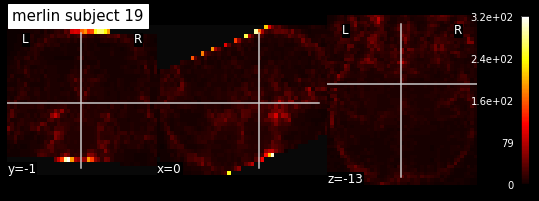

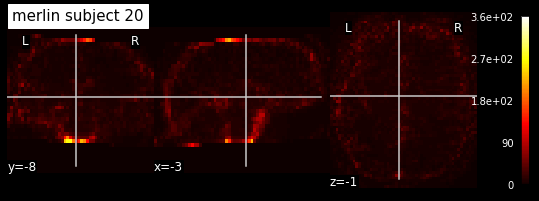

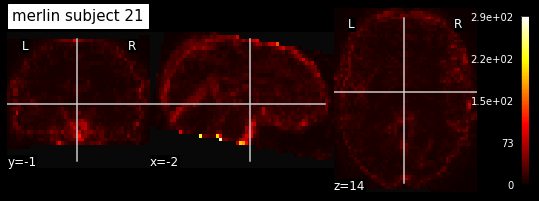

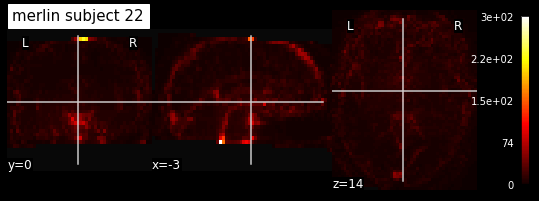

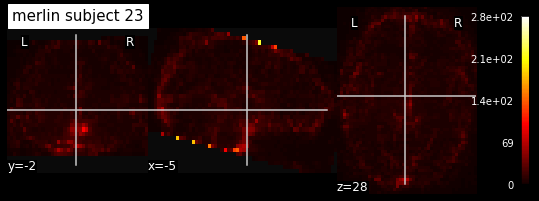

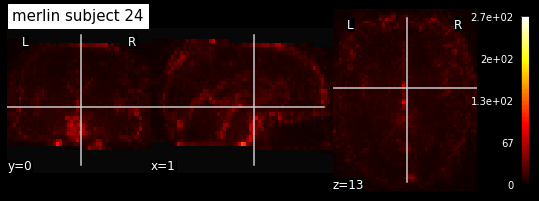

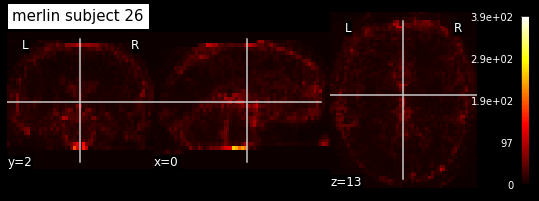

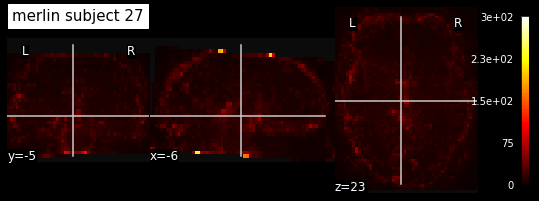

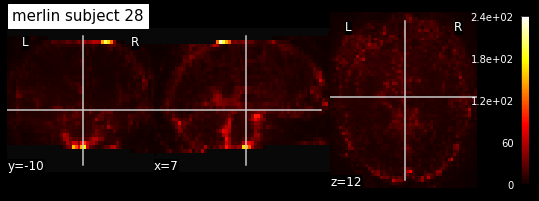

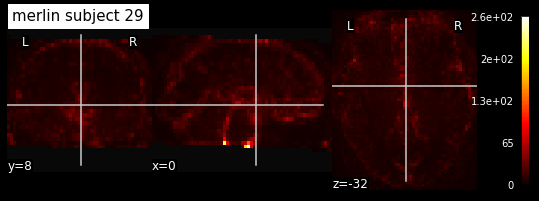

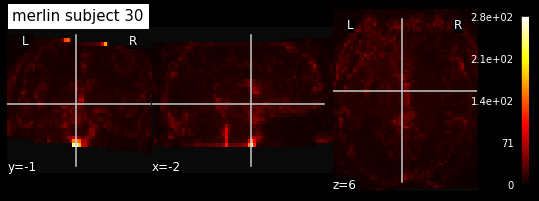

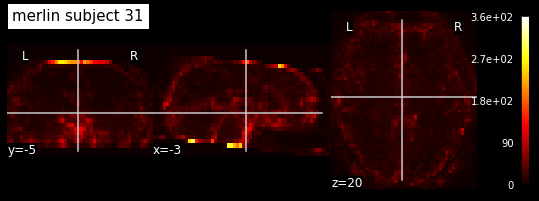

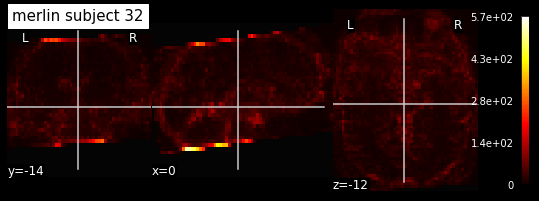

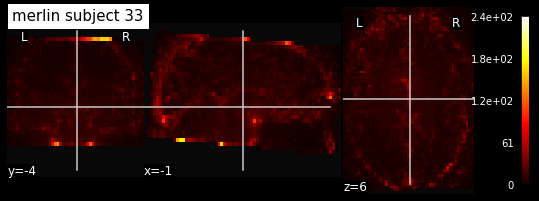

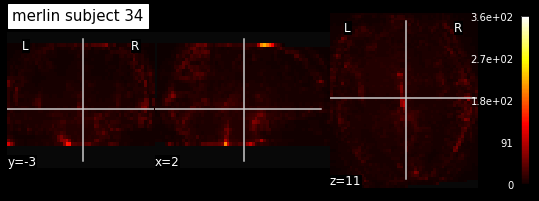

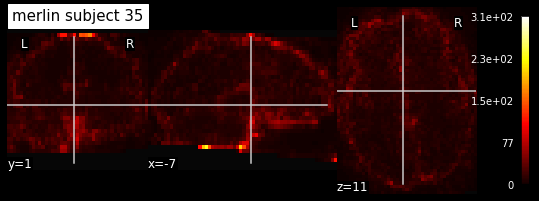

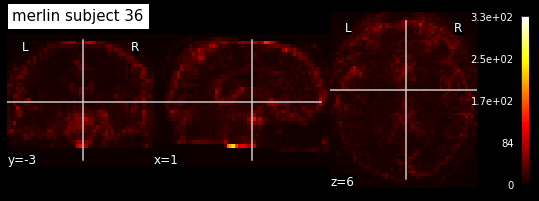

In [142]:
for id_subject in range(min_sub, max_sub):
    if id_subject != null_sub :
        plot_std(id_subject)